# Importing libraries 

In [4]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

import tensorflow as tf

In [7]:
DATA_DIR = '/kaggle/input/flickr8k'
OUTPUT_DIR = '/kaggle/working'

# Extract features from image

In [3]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output) #excluding the last output layer because we won't need it, we'll pass the data from the convolution to the lstm model

#summarizing model
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
#extracting features from image
features = {}
directory = os.path.join(DATA_DIR, 'Images')
for img_name in tqdm(os.listdir(directory)):
    #loading image from file 
    file = directory + '/' + img_name
    img = load_img(file, target_size=(224, 224))

    #Convert image to array
    img = img_to_array(img)

    #reshape image
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))

    #preprocessing of the image
    img = preprocess_input(img)

    #extracting the features
    feature = model.predict(img, verbose=0)

    #getting the id of image
    img_id = img_name.split('.')[0]

    #storing features 
    features[img_id] = feature
    

  0%|          | 0/8091 [00:00<?, ?it/s]

In [5]:
#storing features in a pickle file
#so we don't have to redo the whole process again, therefore saving time

pickle.dump(features, open(os.path.join(OUTPUT_DIR, 'features.pkl'), 'wb'))

In [8]:
#Loading the features stored in the pickle file
with open(os.path.join(OUTPUT_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

# Loading captions

In [9]:
with open(os.path.join(DATA_DIR, 'captions.txt'), 'r') as f:
    next(f)
    cpts = f.read()

In [10]:
cpts

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n1002674143_1b742ab4b8.j

In [11]:
#Mapping images to captions
mapping = {}

#Lines processing
for line in tqdm(cpts.split('\n')):
    #splitting by comma
    tokens = line.split(',')
    
    if len(line) < 2: #avoiding the error when captions contains less words than 2
        continue
    
    #link between image and caption 
    img_id, caption = tokens[0], tokens[1:]
    
    img_id = img_id.split('.')[0] #to remove the extension of file
    
    #Convert caption list to string
    caption = " ".join(caption)
    
    #Create list
    if img_id not in mapping:
        mapping[img_id] = []
        
    #storing caption
    mapping[img_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [12]:
len(mapping)

8091

In [13]:
len(features)

8091

In [14]:
def caption_processing(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            
            #converting to lower
            #replacing digits and special caracters with empty string
            #replacing multiple spaces with only one space
            #limiting our caption using tags for our recurrent model
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word)>1]) + ' endseq' 
            captions[i] = caption

In [15]:
mapping['1007320043_627395c3d8']

['A child playing on a rope net .',
 'A little girl climbing on red roping .',
 'A little girl in pink climbs a rope bridge at the park .',
 'A small child grips onto the red ropes at the playground .',
 'The small child climbs on a red ropes on a playground .']

In [16]:
caption_processing(mapping)

In [17]:
mapping['1007320043_627395c3d8']

['startseq child playing on rope net endseq',
 'startseq little girl climbing on red roping endseq',
 'startseq little girl in pink climbs rope bridge at the park endseq',
 'startseq small child grips onto the red ropes at the playground endseq',
 'startseq the small child climbs on red ropes on playground endseq']

In [18]:
all_captions = []
for key  in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
        

In [19]:
len(all_captions)

40455

In [20]:
all_captions

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq',
 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas 

In [21]:
tokenizer = Tokenizer() #Call for the Tokenizer 
tokenizer.fit_on_texts(all_captions) #Give each unique word a token vector
vocab_size = len(tokenizer.word_index) + 1 #Getting how many unique words we have got

In [22]:
#get maximum to pad the sequence for model creation 
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# Train Test Split

In [23]:
img_ids = list(mapping.keys())
split = int(len(img_ids) * 0.9)
split 

7281

In [24]:
train = img_ids[:split] #we split by id our datasets, 90% train and 10% test
test = img_ids[split:]

In [25]:
#we use this function to split the data into batches, that way our session doesn't crash when giving it 7281 data at once
def data_generator(img_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    #Loop over img
    X1, X2, y = [], [], []
    n = 0 #check whether we reached the batch size 
    
    while 1: 
        for key in img_ids:
            n += 1
            captions = mapping[key]
            
            #taking each caption to process it
            for caption in captions:
                #Encode sequence
                seq = tokenizer.texts_to_sequences([caption])[0] #for each word we will be assigning the index
                #split sequence into X, y parse
                for i in range(1, len(seq)):
                    #split into input and output
                    in_seq, out_seq = seq[:i], seq[i]
                    
                    #pad sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    
                    #encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    #storing sequences
                    X1.append(features[key][0]) #first input, of image features
                    X2.append(in_seq) #second input, of text
                    y.append(out_seq) #our output text sequence
                    
            if n == batch_size:
                X1 = np.array(X1)
                X2 = np.array(X2)
                y = np.array(y)
                yield [X1, X2], y
                X1, X2, y = [], [], []
                n = 0

In [26]:
#<start> small child grips onto the red ropes at the playground <end>
# X                       y
#<start>                 small
#<start> small            child
#<start> small child      grips

#<start> small child grips onto the red ropes at the playground <end>

#We call this sequence splitting

# Building Model

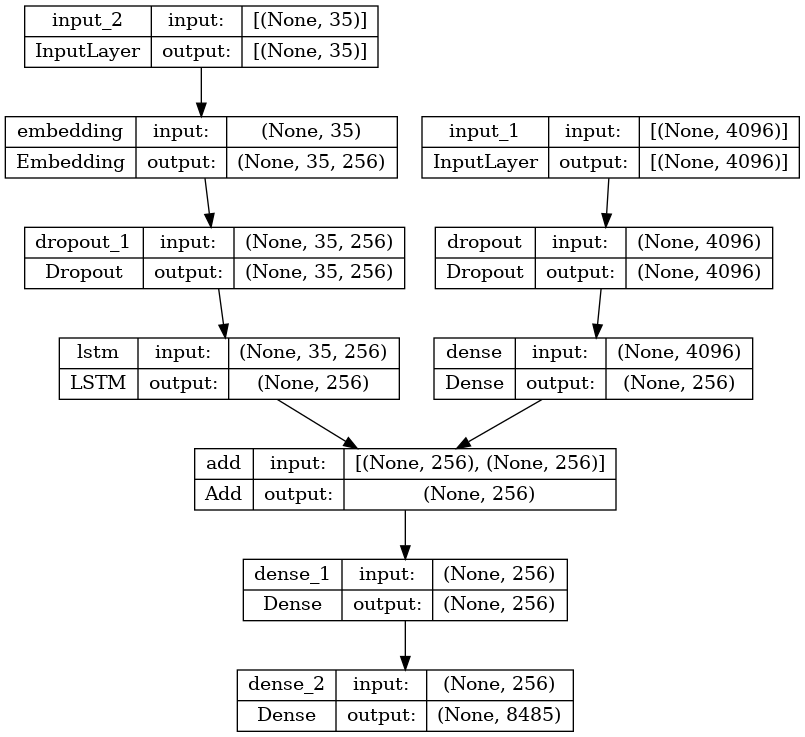

In [27]:
#encoder model
#image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 256)      2172160     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_1[0][0]']                
                                                                                              

In [29]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size
loss = []

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    loss.append(history.history['loss'])

227/227 [==============================] - 63s 279ms/step - loss: 2.1882


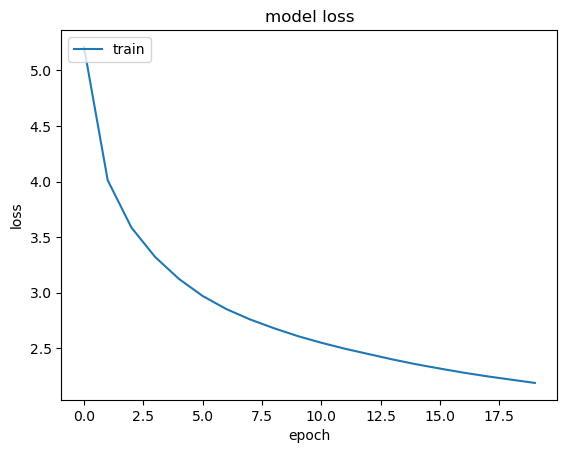

In [38]:
plt.plot(loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
# save the model
model.save(OUTPUT_DIR+'/best_model.h5')

In [31]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [32]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [33]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.524027
BLEU-2: 0.299156


# Visualization of code

---------------------Actual---------------------
startseq child and woman are at waters edge in big city endseq
startseq large lake with lone duck swimming in it with several people around the edge of it endseq
startseq little boy at lake watching duck endseq
startseq young boy waves his hand at the duck in the water surrounded by green park endseq
startseq "two people are at the edge of lake facing the water and the city skyline ." endseq
--------------------Predicted--------------------
startseq man in black tank top fishes in the water endseq


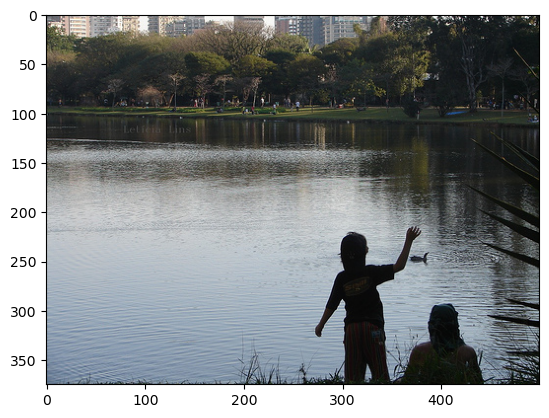

In [34]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(DATA_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    
generate_caption("1022454332_6af2c1449a.jpg")

---------------------Actual---------------------
startseq man drilling hole in the ice endseq
startseq man is drilling through the frozen ice of pond endseq
startseq person in the snow drilling hole in the ice endseq
startseq person standing on frozen lake endseq
startseq two men are ice fishing endseq
--------------------Predicted--------------------
startseq man is drilling in the water endseq


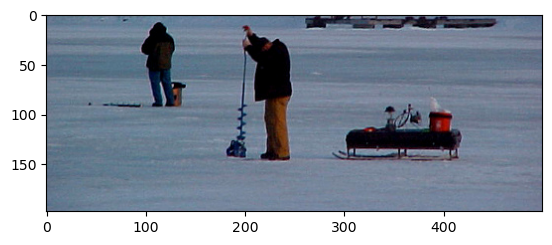

In [35]:
generate_caption('102351840_323e3de834.jpg')

In [44]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [45]:
image_path = '/kaggle/input/new-imgs/new_img.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq woman in costume sits on sidewalk endseq'

In [46]:
loaded_model = tf.keras.models.load_model('/kaggle/working/best_model.h5')

In [47]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 256)      2172160     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_1[0][0]']                
                                                                                              

In [48]:
predict_caption(loaded_model, feature, tokenizer, max_length)

'startseq woman in costume sits on sidewalk endseq'